In [1]:
import rasterio
import numpy as np
from rasterio import features
import geopandas as gpd
from shapely.geometry import shape
import os

def analyze_single_water_mask(water_mask_path):
    """
    Convert binary water mask to vector polygons and calculate area statistics
    Similar to GIS zonal statistics approach
    
    Parameters:
    water_mask_path (str): Path to binary water mask TIFF
    
    Returns:
    dict: Statistics including total area, count of features, and individual feature areas
    """
    
    print(f"Analyzing: {os.path.basename(water_mask_path)}")
    
    with rasterio.open(water_mask_path) as src:
        # Read the binary mask
        mask = src.read(1).astype(np.uint8)
        transform = src.transform
        crs = src.crs
        
        print(f"Raster info:")
        print(f"  - CRS: {crs}")
        print(f"  - Shape: {mask.shape}")
        print(f"  - Pixel size: {abs(transform[0]):.1f}m x {abs(transform[4]):.1f}m")
        print(f"  - Unique values: {np.unique(mask)}")
        
        # Convert raster to vector polygons (only value 1 = water)
        water_shapes = []
        print("\nConverting raster to polygons...")
        
        for geom, value in features.shapes(mask, mask=(mask == 1), transform=transform):
            if value == 1:  # Only water pixels
                water_shapes.append(shape(geom))
    
    if not water_shapes:
        print("No water features found!")
        return {
            'total_area_km2': 0.0,
            'total_area_m2': 0.0,
            'feature_count': 0,
            'individual_areas_km2': []
        }
    
    print(f"Found {len(water_shapes)} water features")
    
    # Create GeoDataFrame
    gdf = gpd.GeoDataFrame(geometry=water_shapes, crs=crs)
    
    # Calculate area for each polygon
    print("Calculating areas...")
    
    if gdf.crs and not gdf.crs.is_geographic:
        # Already in projected coordinates, use direct area calculation
        gdf['area_m2'] = gdf.geometry.area
        print("Using projected CRS for area calculation")
    else:
        # Project to calculate area properly
        print("Projecting to UTM for area calculation...")
        gdf_proj = gdf.to_crs('EPSG:32645')  # UTM Zone 45N for Nepal
        gdf['area_m2'] = gdf_proj.geometry.area
    
    # Convert to km²
    gdf['area_km2'] = gdf['area_m2'] / 1e6
    
    # Calculate statistics
    total_area_m2 = gdf['area_m2'].sum()
    total_area_km2 = total_area_m2 / 1e6
    feature_count = len(gdf)
    individual_areas_km2 = gdf['area_km2'].tolist()
    
    # Sort by area (largest first)
    gdf_sorted = gdf.sort_values('area_km2', ascending=False)
    
    print(f"\nRESULTS:")
    print(f"  Total water area: {total_area_km2:.6f} km²")
    print(f"  Total water area: {total_area_m2:.0f} m²")
    print(f"  Number of water features: {feature_count}")
    
    if feature_count > 0:
        print(f"  Largest feature: {gdf['area_km2'].max():.6f} km²")
        print(f"  Smallest feature: {gdf['area_km2'].min():.6f} km²")
        print(f"  Mean feature size: {gdf['area_km2'].mean():.6f} km²")
        
        # Show top 5 largest features
        print(f"\nTop 5 largest features:")
        for i, (idx, row) in enumerate(gdf_sorted.head(5).iterrows()):
            print(f"    {i+1}. {row['area_km2']:.6f} km² ({row['area_m2']:.0f} m²)")
    
    stats = {
        'total_area_km2': total_area_km2,
        'total_area_m2': total_area_m2,
        'feature_count': feature_count,
        'largest_feature_km2': gdf['area_km2'].max() if feature_count > 0 else 0.0,
        'smallest_feature_km2': gdf['area_km2'].min() if feature_count > 0 else 0.0,
        'mean_feature_size_km2': gdf['area_km2'].mean() if feature_count > 0 else 0.0,
        'individual_areas_km2': individual_areas_km2
    }
    
    return stats, gdf


In [5]:
test_file = "/Users/varyabazilova/Desktop/glacial_lakes/super_lakes/water/langtang2021/2021-10-15_water_mask.tif"
    
if os.path.exists(test_file):
    stats, gdf = analyze_single_water_mask(test_file)
        
    # Optionally save the vector polygons
    vector_file = test_file.replace('.tif', '_polygons.gpkg')
    if stats['feature_count'] > 0:
        gdf.to_file(vector_file, driver='GPKG')
        print(f"\nVector polygons saved to: {os.path.basename(vector_file)}")
else:
    print(f"File not found: {test_file}")
    print("Available files:")
    import glob
    water_dir = "/Users/varyabazilova/Desktop/glacial_lakes/super_lakes/water/langtang2023"
    files = glob.glob(os.path.join(water_dir, "*water_mask.tif"))
    for f in files[:5]:  # Show first 5
        print(f"  {os.path.basename(f)}")

Analyzing: 2021-10-15_water_mask.tif
Raster info:
  - CRS: EPSG:32645
  - Shape: (5203, 4640)
  - Pixel size: 3.0m x 3.0m
  - Unique values: [0 1]

Converting raster to polygons...
Found 122 water features
Calculating areas...
Using projected CRS for area calculation

RESULTS:
  Total water area: 0.929736 km²
  Total water area: 929736 m²
  Number of water features: 122
  Largest feature: 0.176796 km²
  Smallest feature: 0.000450 km²
  Mean feature size: 0.007621 km²

Top 5 largest features:
    1. 0.176796 km² (176796 m²)
    2. 0.146511 km² (146511 m²)
    3. 0.054252 km² (54252 m²)
    4. 0.050931 km² (50931 m²)
    5. 0.046350 km² (46350 m²)

Vector polygons saved to: 2021-10-15_water_mask_polygons.gpkg


# plot


In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [13]:

df2021 = pd.read_csv('/Users/varyabazilova/Desktop/glacial_lakes/super_lakes/water_stats/langtang2021/water_summary_table_2021.csv')
df =df2021

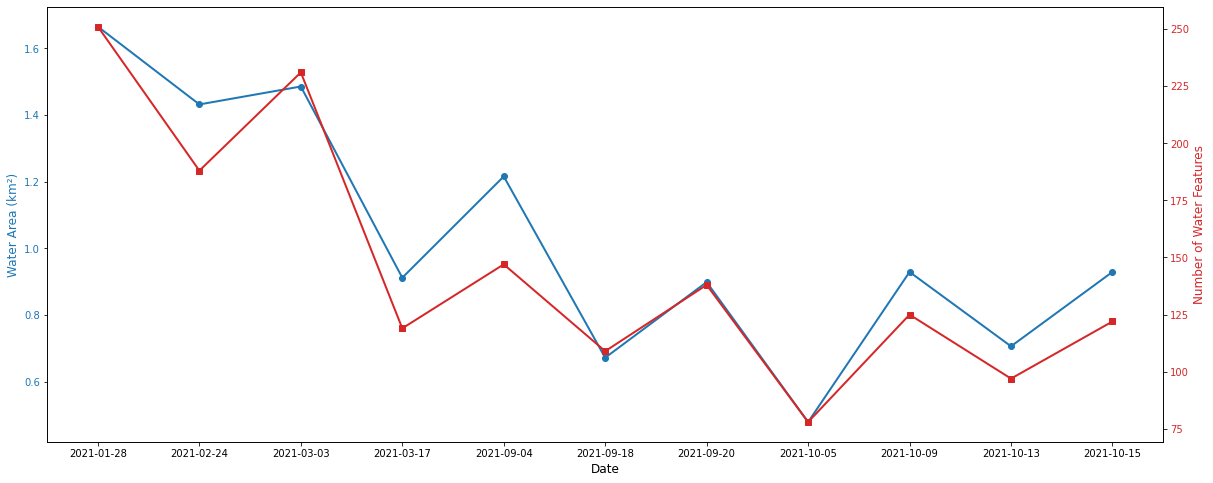

In [17]:
fig, ax1 = plt.subplots(figsize=(20, 8))
    
# Plot water area on left y-axis
color1 = 'tab:blue'
ax1.set_xlabel('Date', fontsize=12)
ax1.set_ylabel('Water Area (km²)', color=color1, fontsize=12)
line1 = ax1.plot(df['date'], df['total_area_km2'], color=color1, marker='o', 
                 linewidth=2, markersize=6, label='Water Area')
ax1.tick_params(axis='y', labelcolor=color1)
    
# Create second y-axis for feature count
ax2 = ax1.twinx()
color2 = 'tab:red'
ax2.set_ylabel('Number of Water Features', color=color2, fontsize=12)
line2 = ax2.plot(df['date'], df['feature_count'], color=color2, marker='s', 
                 linewidth=2, markersize=6, label='Feature Count')
ax2.tick_params(axis='y', labelcolor=color2)

output_file = "/Users/varyabazilova/Desktop/glacial_lakes/super_lakes/codes_by_claude/water_timeseries_2021.png"
plt.savefig(output_file, dpi=300, bbox_inches='tight')

Loaded 11 records from 2021-01-28 to 2021-10-15
Plot saved to: /Users/varyabazilova/Desktop/glacial_lakes/super_lakes/codes_by_claude/water_timeseries_2021.png


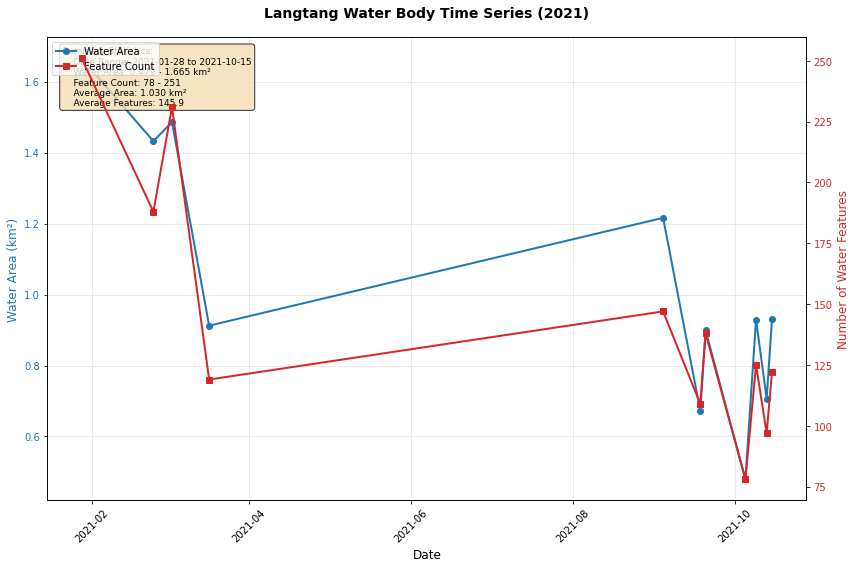


Key Insights:
Peak water area: 1.665 km² on 2021-01-28
Peak feature count: 251 features on 2021-01-28
Minimum water area: 0.479 km² on 2021-10-05
Minimum feature count: 78 features on 2021-10-05

Monthly averages:
Jan: 1.665 km², 251.0 features
Feb: 1.432 km², 188.0 features
Mar: 1.199 km², 175.0 features
Sep: 0.929 km², 131.3 features
Oct: 0.761 km², 105.5 features
